In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl

#style your matplotlib
mpl.style.use("seaborn-darkgrid")

In [2]:
from tqdm import tqdm # show progress bar of for loop

In [3]:
#list of files in train folder
files = os.listdir("../input/mma-facial-expression/MMAFEDB/train/")
files

['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']

In [4]:
#now crate image and label array
image_array=[]   #its a list later will convert it into array
label_array=[]

path = "../input/mma-facial-expression/MMAFEDB/train/"

#loop through each sub folder in train
for i in range (len(files)):
    file_sub = os.listdir(path+files[i])
    
    #print(len(file_sub))
    
    #loop thorugh each file
    if(files[i]=="neutral" or files[i]=="happy"):
        for k in tqdm(range(18000)):
            #read image
            img = cv2.imread(path+files[i] + "/"+file_sub[k])
            #convert image from BGR to RGB
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            #append img array with img
            image_array.append(img)
            label_array.append(i)
            #i is integer from 0 to 6
            
    else:
        for k in tqdm(range(len(file_sub))):
            #read image
            img = cv2.imread(path+files[i] + "/"+file_sub[k])
            #convert image from BGR to RGB
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            #append img array with img
            image_array.append(img)
            label_array.append(i)
            #i is integer from 0 to 6
            
            

100%|██████████| 18000/18000 [01:09<00:00, 257.55it/s]


In [5]:
a,b = np.unique(label_array,return_counts='True')
a

array([0, 1, 2, 3, 4, 5, 6])

In [6]:
b
#due to low memory issue we will reduce our training dataset to 18000 for 29384 and 28592


array([ 8113,  4859,  6566, 18000, 12223,  3231, 18000])

In [7]:
#free some ram memory
import gc
gc.collect()

85

In [8]:
#divide image array by 255.0
#this will scale image pixel from 0-255 to 0-1
image_array=np.array(image_array)/255.0
#convert label list to array
label_array = np.array(label_array)

In [9]:
#image_array[0]
#label_array

In [10]:
# now define label_to_text 
#['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
label_to_text={0:"surprise",1:"fear",2:"angry",3:"neutral",4:"sad",5:"disgust",6:"happy"}

In [11]:
# this dic can convert label to text_label
# example
label_to_text[1]

'fear'

In [12]:
# now shuffle and split image and labels into train and test
from sklearn.model_selection import train_test_split
image_array,X_test,Y_train,Y_test=train_test_split(image_array,label_array,test_size=0.1)
# you can change test size 
# we are using 10% for validation

#now before running this block change X_train to image_array to save ram memory
gc.collect()

0

In [13]:
# if you want to see image and label
# define dic for converting label to test_label
#['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
label_to_text={0:"surprise",1:"fear",2:"angry",3:"neutral",4:"sad",5:"disgust",6:"happy"}

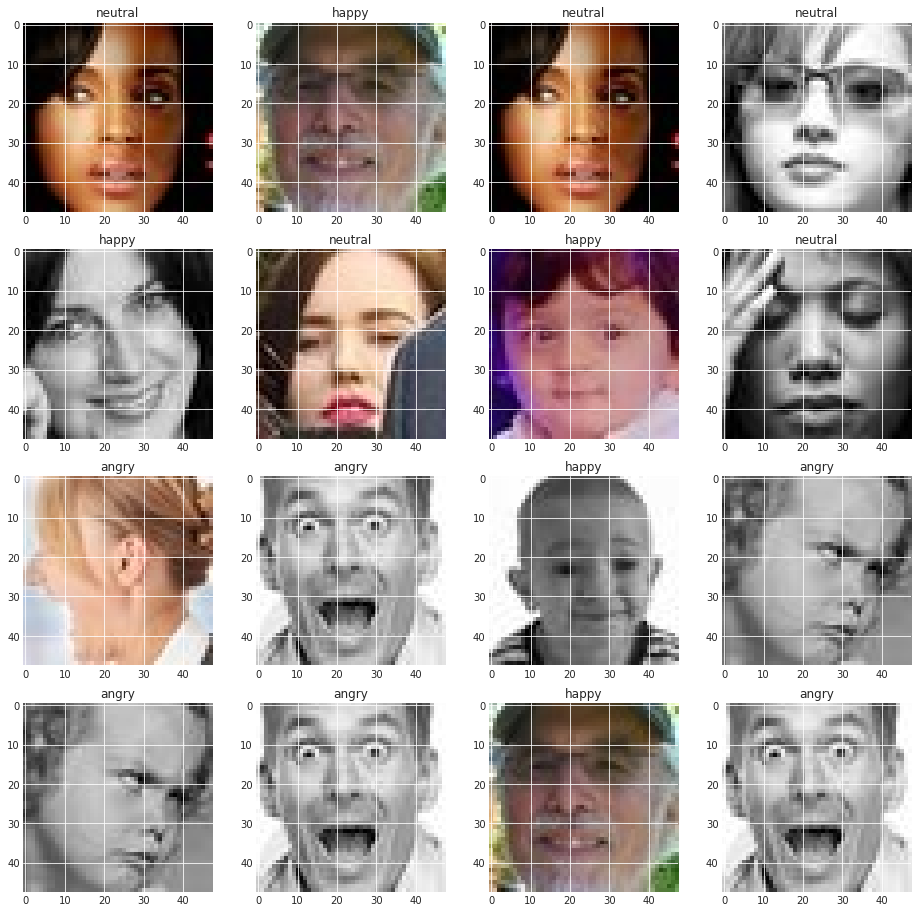

In [14]:
# define a function 
def show_examples(image,label,idx):
    # create 4x4 figure
    fig,axes=plt.subplots(nrows=4,ncols=4,figsize=(16,16))
    # loop through each figure
    for idx_f,ax in zip(idx,axes.ravel()):
        # add image to figure
        ax.imshow(image[idx_f].squeeze(),cmap="gray")
        # add title to each figure
        ax.set_title(label_to_text[label[idx_f]])
    plt.show()
idx=np.random.choice(16,16)
show_examples(image_array,Y_train,idx)

In [15]:
# now we will start with our model
# import all library required for model
from tensorflow.keras import layers,callbacks,utils,applications,optimizers
from keras.models import Sequential,Model,load_model

In [16]:
model=Sequential()
# I will use MobileNetV2 as an pretrained model 
pretrained_model=applications.MobileNetV2(input_shape=(48,48,3),include_top=False,
                                         weights="imagenet")
# you can use other pretrained model to increase accuracy or increase frame rate
# change all non-trainable layer to trainable
pretrained_model.trainable=True
# add pretrained_model to model
model.add(pretrained_model)
model.add(layers.GlobalAveragePooling2D())
# add dropout to increase accuracy by not overfitting
model.add(layers.Dropout(0.3))
# add dense layer as final output
model.add(layers.Dense(1))
model.summary()

2023-02-05 18:11:08.666884: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [17]:
from tensorflow.keras.optimizers import Adam

In [18]:
#compile model

model.compile(optimizer=Adam(0.0001),loss="mean_squared_error",metrics=["mae"])
# run
# starting learning rate is 1e-3
# you can change optimizer, loss function, metrics for better result

In [19]:
# create a model checkpoint to save model
ckp_path="trained_model/model"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=ckp_path,
                                                   monitor="val_mae",
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   mode="auto")
# this checkpoint save model when val_mae is lower then best val_mae
#run

In [20]:
# now we will define learning rate reducer 
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(factor=0.9,
                                              monitor="val_mae",
                                              mode="auto",
                                              cooldown=0,
                                              patience=5,
                                              verbose=1,
                                              min_lr=1e-6)
# this will decrease learning rate when val_mae does't decrease durning last 5 epoch
# verbose is use to show val_mae every epoch

In [21]:
EPOCHS=25
BATCH_SIZE=64
# start training
history=model.fit(image_array,Y_train,
                 validation_data=(X_test,Y_test),
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 callbacks=[model_checkpoint,reduce_lr])

2023-02-05 18:11:14.717626: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
999/999 [==============================] - 309s 303ms/step - loss: 4.1209 - mae: 1.6244 - val_loss: 52.4006 - val_mae: 6.9174
Epoch 2/25
999/999 [==============================] - 302s 302ms/step - loss: 2.8489 - mae: 1.3498 - val_loss: 8.5172 - val_mae: 2.4847
Epoch 3/25
999/999 [==============================] - 303s 303ms/step - loss: 2.5417 - mae: 1.2665 - val_loss: 4.1598 - val_mae: 1.6422
Epoch 4/25
999/999 [==============================] - 302s 303ms/step - loss: 2.2511 - mae: 1.1834 - val_loss: 2.8349 - val_mae: 1.3224
Epoch 5/25
999/999 [==============================] - 303s 304ms/step - loss: 2.0392 - mae: 1.1163 - val_loss: 2.5170 - val_mae: 1.2201
Epoch 6/25
999/999 [==============================] - 304s 305ms/step - loss: 1.8558 - mae: 1.0550 - val_loss: 2.4368 - val_mae: 1.2009
Epoch 7/25
999/999 [==============================] - 305s 305ms/step - loss: 1.6767 - mae: 0.9975 - val_loss: 2.5678 - val_mae: 1.2168
Epoch 8/25
999/999 [===========================

In [22]:
# after training is finished 
# load best model
model.load_weights(ckp_path)

In [23]:
# if you want to see result
prediction_val=model.predict(X_test,batch_size=BATCH_SIZE)

In [24]:
# remember X_test is use for validation and for testing 
# to get beffer result use different data for validation and testing

In [25]:
# prediction value 
prediction_val[:10]

array([[3.3942037 ],
       [1.7027119 ],
       [4.632427  ],
       [4.183124  ],
       [3.260579  ],
       [0.11300002],
       [4.346112  ],
       [3.4514575 ],
       [4.003727  ],
       [5.7370434 ]], dtype=float32)

In [26]:
# original value
Y_test[:10]

array([6, 3, 3, 5, 6, 0, 4, 6, 4, 6])

In [27]:
# now convert model to tensorflow lite model 
converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert()

#save model 
with open("model.tflite","wb") as f:
    f.write(tflite_model)

2023-02-05 20:21:05.075233: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2023-02-05 20:21:26.139533: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-02-05 20:21:26.139759: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-02-05 20:21:26.169906: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.017ms.
  function_optimizer